In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import torch

import seaborn as sns

from privacy_utils import get_sigma_epsilon


sns.set_style("whitegrid")

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r"""
\usepackage{sansmath}
\sansmath
""" #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif' # Choose a nice font here

fontsize = 15

In [113]:
def plot_fig(results, iwerm_gap, erm_gap, output_path=None):
    plt.plot(results['sigma'], results['trn wg acc'] - results['tst wg acc'], label="DP")
    plt.plot(results['sigma'], iwerm_gap * np.ones(len(results['sigma'])), label="IWERM")
    plt.plot(results['sigma'], erm_gap * np.ones(len(results['sigma'])), label="ERM")

    plt.xscale("log")
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel("sigma", fontsize=fontsize)
    plt.ylabel("worst-group accuracy gap", fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    if output_path is not None:
        plt.savefig(output_path)
    
def get_losses(model, loader):
    losses = []
    for X, y in loader:
        y_pred = model(X.cuda())
        loss = torch.nn.functional.nll_loss(
            y_pred, y.cuda(), reduction="none").detach().cpu().numpy()
        losses.append(loss)        
    return np.concatenate(losses)

#def mia_opt_loss_threshold(train_losses, test_losses):
#    # MIA metric is balanced accuracy.
#    def _compute_mia_metric(threshold, train_losses, test_losses):
#        return 0.5 * (np.mean(train_losses <= threshold) + np.mean(test_losses > threshold))
#    
#    best_mia_acc = 0.
#    for thresh in np.concatenate([train_losses, test_losses]):
#        mia_acc = _compute_mia_metric(thresh, train_losses, test_losses)
#        if mia_acc > best_mia_acc:
#            best_mia_acc = mia_acc
#    
#    return best_mia_acc, thresh

def mia_opt_loss_threshold(train_losses, test_losses):
    # MIA metric is balanced accuracy.
    losses = np.concatenate([train_losses, test_losses])
    ans = np.concatenate([np.zeros(len(train_losses)), np.ones(len(test_losses))])
    ind = np.argsort(losses)
    losses, ans = losses[ind], ans[ind]
    weights = [1 / 2 / (ans==0).sum(), 1 / 2 / (ans==1).sum()]
    
    mia_acc = 0.5
    best_mia_acc = (0., losses[0])
    for i, thresh in enumerate(losses):
        if (i+1) < len(losses) and losses[i+1] == thresh:
            continue
        if ans[i] == 0:
            mia_acc = mia_acc + weights[0]
        else:
            mia_acc = mia_acc - weights[1]
            
        if mia_acc > best_mia_acc[0]:
            best_mia_acc = (mia_acc, thresh)
    
    return best_mia_acc[0], best_mia_acc[1]

#train_losses = get_losses(model, train_loader)
#test_losses = get_losses(model, test_loader)
#mia_acc, _ = mia_opt_loss_threshold(train_losses, test_losses) # Attack accuracy from 50% to 100%
#mia_adv = 2 * mia_acc - 1  # Attack advantage from 0 to 1

In [160]:
ds_name = "celebA"

sigmas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
log_paths = []
for sigma in sigmas:
    log_paths.append(f"erm-dp_resnet50-lr1e-3-dpsgd_1e-5_{sigma}_1.0_0.0001")

cols = ["acc_avg", "acc_wg", "acc_y:notblond_male:0", "acc_y:notblond_male:1", "acc_y:blond_male:0", "acc_y:blond_male:1"]
col_names = ["acc", "acc_wg", "notblond_male:0", "notblond_male:1", "blond_male:0", "blond_male:1"]

results = {}
for sigma, log_path in zip(sigmas, log_paths):
    results.setdefault("sigma", []).append(sigma)

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
    train_res = df[["epoch", "acc_avg", "acc_wg"]].values
    results.setdefault("trn acc", []).append(train_res[-1][1])
    results.setdefault("trn wg acc", []).append(train_res[-1][2])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/val_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg"]].values
    results.setdefault("val acc", []).append(res[-1][1])
    results.setdefault("val wg acc", []).append(res[-1][2])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg", "epsilon"]].values.tolist()
    results.setdefault("tst acc", []).append(res[-1][1])
    results.setdefault("tst wg acc", []).append(res[-1][2])
    results.setdefault("epsilon", []).append(res[-1][3])

    preds = joblib.load(f"../logs/{ds_name}/{log_path}/preds.pkl")
    trn_losses = torch.nn.functional.nll_loss(preds["trn"], torch.cat(preds["trny"]), reduction="none").detach().cpu().numpy()
    tst_losses = torch.nn.functional.nll_loss(preds["tst"], torch.cat(preds["tsty"]), reduction="none").detach().cpu().numpy()
    mia_acc, _ = mia_opt_loss_threshold(trn_losses, tst_losses) # Attack accuracy from 50% to 100%
    mia_adv = 2 * mia_acc - 1  # Attack advantage from 0 to 1
    results.setdefault("attack adv", []).append(mia_adv)
    
for k, v in results.items():
    results[k] = np.array(v)

log_path = "erm-resnet50"
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
erm_trn_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
erm_tst_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
erm_gap = (erm_trn_acc_wg - erm_tst_acc_wg)
preds = joblib.load(f"../logs/{ds_name}/{log_path}/preds.pkl")
trn_losses = torch.nn.functional.nll_loss(preds["trn"], torch.cat(preds["trny"]), reduction="none").detach().cpu().numpy()
tst_losses = torch.nn.functional.nll_loss(preds["tst"], torch.cat(preds["tsty"]), reduction="none").detach().cpu().numpy()
mia_acc, _ = mia_opt_loss_threshold(trn_losses, tst_losses) # Attack accuracy from 50% to 100%
erm_mia_adv = 2 * mia_acc - 1  # Attack advantage from 0 to 1

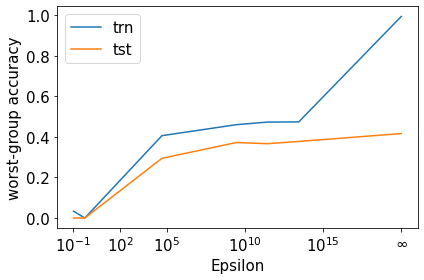

In [115]:
epsilon = np.concatenate([[1e20], results['epsilon']])
trn_wg_acc = np.concatenate(([erm_trn_acc_wg], results['trn wg acc']))
tst_wg_acc = np.concatenate(([erm_tst_acc_wg], results['tst wg acc']))

ticks_ = [-1, 2, 5, 10, 15, 20]
plt.plot(epsilon, trn_wg_acc, label="trn")
plt.plot(epsilon, tst_wg_acc, label="tst")
plt.xscale("log")
plt.xticks(fontsize=fontsize, ticks=[float(10**i) for i in ticks_], labels=[f"$10^{{{eps}}}$" for eps in ticks_[:-1]] + ['$\infty$'])
plt.yticks(fontsize=fontsize)
plt.xlabel("Epsilon", fontsize=fontsize)
plt.ylabel("worst-group accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_wgacc_{ds_name}.png")

In [161]:
iwerm_results

{'wds': array([0.  , 0.01, 0.1 , 1.  ]),
 'trn acc': array([0.98338145, 0.92996252, 0.85091233, 0.85091233]),
 'trn wg acc': array([0.97590363, 0.24441241, 0.        , 0.        ]),
 'tst acc': array([0.94709951, 0.9448452 , 0.86674684, 0.86674684]),
 'tst wg acc': array([0.48888889, 0.30000001, 0.        , 0.        ])}

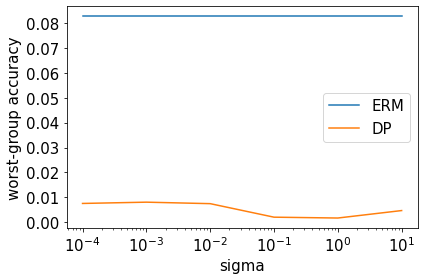

In [63]:
plt.plot(results['sigma'], erm_mia_adv * np.ones(len(results['sigma'])), label="ERM")
plt.plot(results['sigma'], results['attack adv'], label="DP")


plt.xscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("sigma", fontsize=fontsize)
plt.ylabel("worst-group accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
#plt.savefig(f"figs/dpdg_acc_{ds_name}.png")

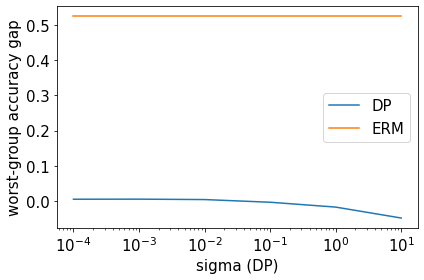

In [60]:
plt.plot(results['sigma'], results['trn wg acc'] - results['tst wg acc'], label="DP")
#plt.plot(iwerm_results['wds'], iwerm_results['trn wg acc'] - iwerm_results['tst wg acc'], label="IWERM")
#plt.plot(results['sigma'], iwerm_gap * np.ones(len(results['sigma'])), label="IWERM")
plt.plot(results['sigma'], erm_gap * np.ones(len(results['sigma'])), label="ERM")

plt.xscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("sigma (DP)", fontsize=fontsize)
plt.ylabel("worst-group accuracy gap", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_{ds_name}.png")

In [157]:
ds_name = "utkface"

sigmas = [1.0, 0.1, 0.01, 0.001, 0.0001][::-1]
log_paths = [
    
]
for sigma in sigmas:
    log_paths.append(f"erm-dp_resnet50-lr1e-3-dpsgd_1e-5_{sigma}_1.0_0.001")

#cols = ["acc_avg", "acc_wg", "acc_y:notblond_male:0", "acc_y:notblond_male:1", "acc_y:blond_male:0", "acc_y:blond_male:1"]
#col_names = ["acc", "acc_wg", "notblond_male:0", "notblond_male:1", "blond_male:0", "blond_male:1"]
subgroup_names = [
    'acc_y:male_race:White',
    'acc_y:male_race:Black',
    'acc_y:male_race:Asian',
    'acc_y:male_race:Indian',
    'acc_y:male_race:Others',
    'acc_y:female_race:White',
    'acc_y:female_race:Black',
    'acc_y:female_race:Asian',
    'acc_y:female_race:Indian',
    'acc_y:female_race:Others',
]
    
results = {}
for sigma, log_path in zip(sigmas, log_paths):
    results.setdefault("sigma", []).append(sigma)

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
    train_res = df[["epoch", "acc_avg", "acc_wg"] + subgroup_names].values
    results.setdefault("trn acc", []).append(train_res[-1][1])
    results.setdefault("trn wg acc", []).append(train_res[-1][2])
    for i, name in enumerate(subgroup_names):
        results.setdefault(f"trn {name}", []).append(train_res[-1][i+3])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/val_eval.csv")
    val_res = df[["epoch", "acc_avg", "acc_wg"]].values
    results.setdefault("val acc", []).append(res[-1][1])
    results.setdefault("val wg acc", []).append(res[-1][2])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg", "epsilon"] + subgroup_names].values.tolist()
    results.setdefault("tst acc", []).append(res[-1][1])
    results.setdefault("tst wg acc", []).append(res[-1][2])
    results.setdefault("epsilon", []).append(res[-1][3])
    for i, name in enumerate(subgroup_names):
        results.setdefault(f"tst {name}", []).append(res[-1][i+4])
    
for k, v in results.items():
    results[k] = np.array(v)
    
iwerm_paths = ["iwerm-resnet50"]
wds = [0., 0.001, 0.01, 0.1]
for wd in wds[1:]:
    iwerm_paths.append(f"iwerm-resnet50_wd{wd}")

iwerm_results = {}
for wd, log_path in zip(wds, iwerm_paths):
    iwerm_results.setdefault("wds", []).append(wd)

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg"] + subgroup_names].values
    iwerm_results.setdefault("trn acc", []).append(res[-1][1])
    iwerm_results.setdefault("trn wg acc", []).append(res[-1][2])
    for i, name in enumerate(subgroup_names):
        iwerm_results.setdefault(f"trn {name}", []).append(res[-1][i+3])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg"] + subgroup_names].values.tolist()
    iwerm_results.setdefault("tst acc", []).append(res[-1][1])
    iwerm_results.setdefault("tst wg acc", []).append(res[-1][2])
    for i, name in enumerate(subgroup_names):
        iwerm_results.setdefault(f"tst {name}", []).append(res[-1][i+3])
        
for k, v in iwerm_results.items():
    iwerm_results[k] = np.array(v)
        
log_path = "iwerm-resnet50"
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
trn_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
tst_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
iwerm_gap = (trn_acc_wg - tst_acc_wg)

log_path = "erm-resnet50"
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
trn_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
tst_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
erm_gap = (trn_acc_wg - tst_acc_wg)


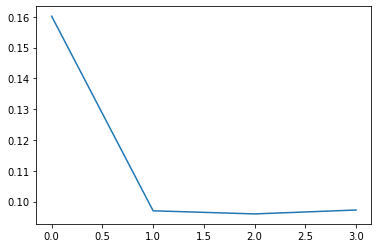

In [158]:
ret = []
for name in subgroup_names:
    ret.append(np.abs(results[f"trn {name}"] - results[f"tst {name}"]))
plt.plot(np.max(np.array(ret), axis=0))

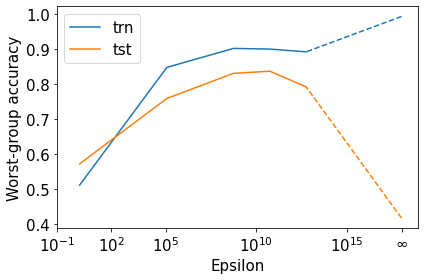

In [136]:
epsilon = np.concatenate([[1e18], results['epsilon']])
trn_wg_acc = np.concatenate(([erm_trn_acc_wg], results['trn wg acc']))
tst_wg_acc = np.concatenate(([erm_tst_acc_wg], results['tst wg acc']))

ticks_ = [-1, 2, 5, 10, 15, 18]
line, = plt.plot(epsilon[1:], trn_wg_acc[1:], label="trn")
plt.plot(epsilon[0: 2], trn_wg_acc[0: 2], color=line.get_color(), ls='--')
line, = plt.plot(epsilon[1:], tst_wg_acc[1:], label="tst")
plt.plot(epsilon[0: 2], tst_wg_acc[0: 2], color=line.get_color(), ls='--')
plt.xscale("log")
plt.xticks(fontsize=fontsize, ticks=[float(10**i) for i in ticks_], labels=[f"$10^{{{eps}}}$" for eps in ticks_[:-1]] + ['$\infty$'])
plt.yticks(fontsize=fontsize)
plt.xlabel("Epsilon", fontsize=fontsize)
plt.ylabel("Worst-group accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_wgacc_{ds_name}.png")

In [ ]:
df.columns

array([1.00000000e+40, 1.34544747e-01, 1.78553920e+00, 1.14811427e+05,
       5.42401581e+08, 5.49924016e+10, 5.49999240e+12])

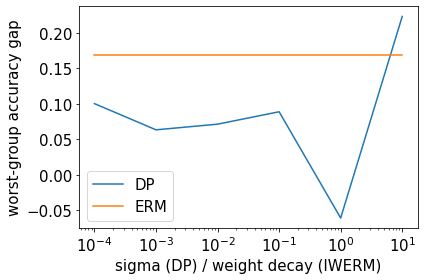

In [113]:
plt.plot(results['sigma'], results['trn wg acc'] - results['tst wg acc'], label="DP")
#plt.plot(iwerm_results['wds'], iwerm_results['trn wg acc'] - iwerm_results['tst wg acc'], label="IWERM")
#plt.plot(results['sigma'], iwerm_gap * np.ones(len(results['sigma'])), label="IWERM")
plt.plot(results['sigma'], erm_gap * np.ones(len(results['sigma'])), label="ERM")

plt.xscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("sigma (DP) / weight decay (IWERM)", fontsize=fontsize)
plt.ylabel("worst-group accuracy gap", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_{ds_name}.png")

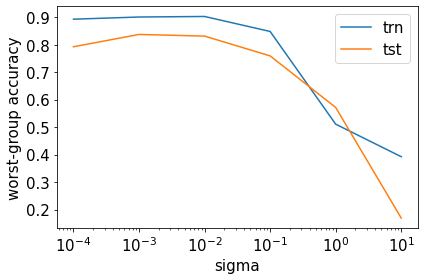

In [97]:
plt.plot(results['sigma'], results['trn wg acc'], label="trn")
plt.plot(results['sigma'], results['tst wg acc'], label="tst")
plt.xscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("sigma", fontsize=fontsize)
plt.ylabel("worst-group accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_acc_{ds_name}.png")

In [ ]:
results[]

# iNaturalist

In [213]:
ds_name = "inaturalist"

clip = "100.0"
sigmas = [0.0001, "0.00001", "0.000001"][::-1]

clip = "1.0"
sigmas = [1.0, 0.1, 0.01, 0.001, 0.0001][::-1]

#clip = "10.0"
#sigmas = [0.001, 0.0001, "0.00001", "0.000001"][::-1]
log_paths = []
for sigma in sigmas:
    log_paths.append(f"erm-dp_resnet18-lr1e-3-dpsgd_1e-5_{sigma}_{clip}_0.0001")
    
results = {}
for sigma, log_path in zip(sigmas, log_paths):
    results.setdefault("sigma", []).append(sigma)

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
    train_res = df[["epoch", "acc_avg", "acc_wg"]].values
    results.setdefault("trn acc", []).append(train_res[-1][1])
    results.setdefault("trn wg acc", []).append(train_res[-1][2])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/val_eval.csv")
    val_res = df[["epoch", "acc_avg", "acc_wg"]].values
    results.setdefault("val acc", []).append(res[-1][1])
    results.setdefault("val wg acc", []).append(res[-1][2])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg", "epsilon"]].values.tolist()
    results.setdefault("tst acc", []).append(res[-1][1])
    results.setdefault("tst wg acc", []).append(res[-1][2])
    results.setdefault("epsilon", []).append(res[-1][3])
    
for k, v in results.items():
    results[k] = np.array(v)

log_path = "erm-resnet18-lr1e-3"
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
trn_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
tst_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
erm_gap = (trn_acc_wg - tst_acc_wg)

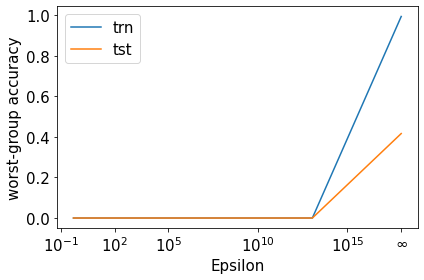

In [214]:
epsilon = np.concatenate([[1e18], results['epsilon']])
trn_wg_acc = np.concatenate(([erm_trn_acc_wg], results['trn wg acc']))
tst_wg_acc = np.concatenate(([erm_tst_acc_wg], results['tst wg acc']))

ticks_ = [-1, 2, 5, 10, 15, 18]
plt.plot(epsilon, trn_wg_acc, label="trn")
plt.plot(epsilon, tst_wg_acc, label="tst")
plt.xscale("log")
plt.xticks(fontsize=fontsize, ticks=[float(10**i) for i in ticks_], labels=[f"$10^{{{eps}}}$" for eps in ticks_[:-1]] + ['$\infty$'])
plt.yticks(fontsize=fontsize)
plt.xlabel("Epsilon", fontsize=fontsize)
plt.ylabel("worst-group accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_wgacc_{ds_name}_{clip}.png")

# Other methods

In [172]:
def get_data(ds_name, wds, paths, early_stopping=False):
    results = {}
    for wd, log_path in zip(wds, paths):
        results.setdefault("wds", []).append(wd)

        df = pd.read_csv(f"../logs/{ds_name}/{log_path}/val_eval.csv")
        res = df[["epoch", "acc_avg", "acc_wg"]].values.tolist()
        if early_stopping:
            val_res = sorted(res, key=lambda x: x[2])
            best_epoch_no = int(val_res[-1][0])
        else:
            best_epoch_no = -1
        results.setdefault("val acc", []).append(res[best_epoch_no][1])
        results.setdefault("val wg acc", []).append(res[best_epoch_no][2])

        df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
        res = df[["epoch", "acc_avg", "acc_wg"]].values
        results.setdefault("trn acc", []).append(res[best_epoch_no][1])
        results.setdefault("trn wg acc", []).append(res[best_epoch_no][2])

        df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
        res = df[["epoch", "acc_avg", "acc_wg"]].values.tolist()
        results.setdefault("tst acc", []).append(res[best_epoch_no][1])
        results.setdefault("tst wg acc", []).append(res[best_epoch_no][2])

    for k, v in results.items():
        results[k] = np.array(v)
    return results

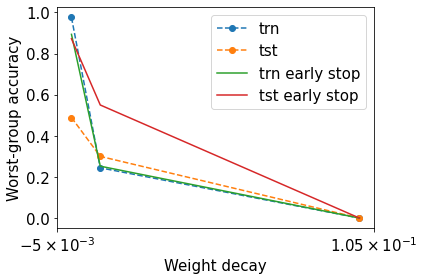

In [223]:
ds_name = "celebA"

paths = ["iwerm-resnet50"]
wds = [0., 0.01, 0.1]
for wd in wds[1:]:
    paths.append(f"iwerm-resnet50_wd{wd}")
    
results = get_data(ds_name, wds, paths, False)
stop_results = get_data(ds_name, wds, paths, True)

plt.plot(results['wds'], results['trn wg acc'], ls='--', label="trn", marker='o')
plt.plot(results['wds'], results['tst wg acc'], ls='--', label="tst", marker='o')
plt.plot(stop_results['wds'], stop_results['trn wg acc'], label="trn early stop")
plt.plot(stop_results['wds'], stop_results['tst wg acc'], label="tst early stop")
plt.xscale("symlog")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("Weight decay", fontsize=fontsize)
plt.ylabel("Worst-group accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_wgacc_iwerm_wd_{ds_name}.png")

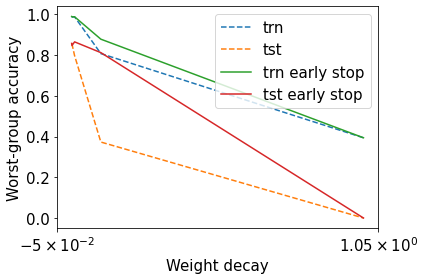

In [215]:
ds_name = "utkface"

paths = ["iwerm-resnet50"]
wds = [0., 0.001, 0.01, 0.1, 1.0]
for wd in wds[1:]:
    paths.append(f"iwerm-resnet50_wd{wd}")
    
results = get_data(ds_name, wds, paths, False)
stop_results = get_data(ds_name, wds, paths, True)

plt.plot(results['wds'], results['trn wg acc'], ls='--', label="trn", )
plt.plot(results['wds'], results['tst wg acc'], ls='--', label="tst")
plt.plot(stop_results['wds'], stop_results['trn wg acc'], label="trn early stop")
plt.plot(stop_results['wds'], stop_results['tst wg acc'], label="tst early stop")
plt.xscale("symlog")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("Weight decay", fontsize=fontsize)
plt.ylabel("Worst-group accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_wgacc_iwerm_wd_{ds_name}.png")

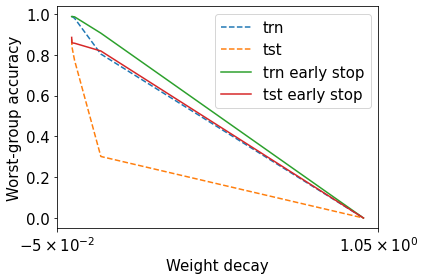

In [222]:

ds_name = "utkface"

paths = ["groupDRO-resnet50"]
wds = [0., 0.001, 0.01, 0.1, 1.0]
for wd in wds[1:]:
    paths.append(f"groupDRO-resnet50_wd{wd}")
    
results = get_data(ds_name, wds, paths, False)
stop_results = get_data(ds_name, wds, paths, True)

plt.plot(results['wds'], results['trn wg acc'], ls='--', label="trn", )
plt.plot(results['wds'], results['tst wg acc'], ls='--', label="tst")
plt.plot(stop_results['wds'], stop_results['trn wg acc'], label="trn early stop")
plt.plot(stop_results['wds'], stop_results['tst wg acc'], label="tst early stop")
plt.xscale("symlog")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("Weight decay", fontsize=fontsize)
plt.ylabel("Worst-group accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_wgacc_gdro_wd_{ds_name}.png")